In [1]:
# disable GPU. Remove this if you've compiled HOOMD for GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'


# import the hoomd, htf packages
import hoomd
import math
import hoomd.htf as htf
import tensorflow as tf
import matplotlib.pyplot as plt
from MDAnalysis import Universe

In [11]:
class RBFExpansion(tf.keras.layers.Layer):
    def __init__(self, low, high, count):
        super(RBFExpansion, self).__init__(name='rbf-layer')
        self.low = low
        self.high = high
        self.centers = tf.cast(tf.linspace(low, high, count), dtype=tf.float32)
        self.gap = self.centers[1] - self.centers[0]

    def call(self, inputs):
        # input shpe
        x = tf.reshape(inputs, (-1,))
        rbf = tf.math.exp(-(x[:,tf.newaxis] - self.centers)**2 / self.gap)
        #remove 0s
        rbf *= tf.cast(x > 1e-5, tf.float32)[:,tf.newaxis]
        return tf.reshape(rbf, tf.concat((tf.shape(inputs), self.centers.shape), axis=0))

class WCARepulsion(tf.keras.layers.Layer):
    def __init__(self, start):
        super(WCARepulsion, self).__init__(name='wca-repulsion')
        # we make it big to ensure 
        self.sigma = self.add_variable(
            shape=(),
            regularizer=lambda x: -1e-3 * x,
            initializer=tf.keras.initializers.Constant(value=start)
        )
    def call(self, nlist):
        rinv = htf.nlist_rinv(nlist)
        true_sig = self.sigma
        rp = (true_sig * rinv)**6
        # make it so anything above cut is 0
        r = tf.norm(nlist[:,:,:3], axis=2)
        r_pair_energy = tf.cast(r < true_sig * 2**(1/3), tf.float32) * rp
        return tf.clip_by_value(r_pair_energy,0, 10)

In [12]:
class RDF(htf.SimModel):
    def setup(self):
        self.rdf = tf.keras.metrics.MeanTensor()
    def compute(self, nlist):
        rdf = htf.compute_rdf(nlist, [0, 5])
        self.rdf(rdf)

In [44]:
class NlistNN(htf.SimModel):
    def setup(self, dim, top_neighs):
        self.dense1 = tf.keras.layers.Dense(dim)
        self.dense2 = tf.keras.layers.Dense(dim)
        self.last = tf.keras.layers.Dense(1)
        # just dummy single variable
        # regularization just pushes location of repulsion to right
        self.repulsion = WCARepulsion(1.0)
        self.rbf = RBFExpansion(0, 5, dim)
        self.top_neighs = top_neighs
        self.avg_ugrad = None
        self.avg_energy = tf.keras.metrics.Mean()
        self.rdf = tf.keras.metrics.MeanTensor()
            
    def compute(self, nlist):
        rinv = htf.nlist_rinv(nlist)
        # closest neighbors have largest value in 1/r, take top
        sorted_n = tf.reshape(tf.sort(rinv, axis=1, direction='DESCENDING'), [-1, self.nneighbor_cutoff])
        top_n = sorted_n[:, :self.top_neighs]
        # start computing gradients of energy wrt model
        # parameters
        with tf.GradientTape() as tape:
            
            # histogram out distances onto grid
            x = self.rbf(top_n)        
            # run through NN
            x = self.dense1(x)
            x = self.dense2(x)
            pair_energy = self.last(x) + self.repulsion(nlist)
                        
            # get total energy
            energy = tf.reduce_sum(pair_energy)
            # get energy with regularization
            aug_energy = energy + sum(model.losses)
        ugrad = tape.gradient(aug_energy, self.trainable_weights)
        if self.avg_ugrad is None:
            self.avg_ugrad = [tf.keras.metrics.MeanTensor() for _ in model.trainable_weights]
        for a,u in zip(self.avg_ugrad,ugrad):
            a.update_state(u)
        self.avg_energy.update_state(aug_energy)
        forces = htf.compute_nlist_forces(nlist, energy)        
        rdf = htf.compute_rdf(nlist, [0, 5])
        self.rdf(rdf)
        # don't output last column of forces, pairwise energy, since it's meaningless here
        return forces[:,:3], energy

In [45]:
# run the simulation
N = 256
hoomd.context.initialize('--mode=cpu --notice-level=0')
rdf_model = RDF(64, output_forces=False)
tfcompute = htf.tfcompute(rdf_model)

rcut = 7.5
system = hoomd.init.create_lattice(
    unitcell=hoomd.lattice.sq(a=4.0),
    n=[int(math.sqrt(N)), int(math.sqrt(N))])
nlist = hoomd.md.nlist.cell()
lj = hoomd.md.pair.lj(r_cut=rcut, nlist=nlist)
lj.pair_coeff.set('A', 'A', epsilon=1, sigma=1)
hoomd.md.integrate.mode_standard(dt=0.005)
hoomd.md.integrate.nve(group=hoomd.group.all(
        )).randomize_velocities(kT=0.5, seed=2)
tfcompute.attach(nlist, rcut)
hoomd.run(1e3)

hoomd.dump.dcd(filename='ref.dcd', period=100, overwrite=True)
hoomd.run(1e4)

In [46]:
ref_rdf = rdf_model.rdf.result().numpy()

In [47]:
# run the simulation
N = 256
period = 10
hoomd.context.initialize('--mode=cpu')
hoomd.util.quiet_status()

# we do NOT compile!
model = NlistNN(64, dim=32, top_neighs=16, output_forces = True)

tfcompute = htf.tfcompute(model)
rcut = 7.5
system = hoomd.init.create_lattice(
    unitcell=hoomd.lattice.sq(a=4.0),
    n=[int(math.sqrt(N)), int(math.sqrt(N))])
nlist = hoomd.md.nlist.cell()
hoomd.md.integrate.mode_standard(dt=0.005)
nvt = hoomd.md.integrate.nvt(group=hoomd.group.all(),kT=0.5, tau=0.2
        )
snapshot = system.take_snapshot()
tfcompute.attach(nlist, r_cut=rcut, period=period)

def sample_cgmodel(desired_frames, equil=1e3):
    system.restore_snapshot(snapshot)
    hoomd.run(equil)
    [a.reset_states() for a in model.avg_ugrad]
    model.avg_energy.reset_states()
    nvt.randomize_velocities(seed=4)
    hoomd.run(desired_frames / period, quiet=True)

*Warning*: Ignoring new options, cannot change execution mode after initialization.


In [48]:
# initial RDF
model.rdf.reset_states()
sample_cgmodel(1e4)
init_rdf = model.rdf.result().numpy()

In [49]:
def iter_refmodel():
    universe = Universe('ref.dcd')
    while True:
        for inputs, ts in htf.iter_from_trajectory(64, universe, r_cut=rcut, period=1):
            #labels = ts.forces
            labels = ts.positions
            yield model(inputs)
    

In [32]:
epochs = 100
batch_size = 64
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
refmodel_iterator = iter_refmodel()
loss = []
net_grad = []
weight_averager = None

for e in range(epochs):
    sample_cgmodel(batch_size)
    cg_grad = [a.result() for a in model.avg_ugrad]
    cg_energy =  model.avg_energy.result().numpy()
    for b in range(batch_size):
        next(refmodel_iterator)
    
    delta_e = model.avg_energy.result().numpy() - cg_energy
    delta_grad = [2 * delta_e * (fp.result() - cg) for fp,cg in zip(model.avg_ugrad, cg_grad)]
    [a.reset_states() for a in model.avg_ugrad]
    model.avg_energy.reset_states()
    
    net_grad.append(sum([tf.reduce_sum(a**2) for a in delta_grad]).numpy())
    loss.append(delta_e**2)
    
    optimizer.apply_gradients(zip(delta_grad, model.trainable_weights))
            
    print(e, loss[-1], net_grad[-1])


0 10132309.633804321 1.0316059e+17
1 286638.9386138916 127019510000000.0
2 1898467.5277209878 1.919185e+16
3 224478.64943526778 40193150000000.0
4 208982.62915644422 81903120000000.0
5 369225.2747806944 3723431000000000.0
6 119824.65647941828 41834747000000.0
7 1666460.6925834566 1.6781745e+16
8 47987.63016039133 14347508000000.0
9 48013.786244764924 22403126000000.0
10 2210054.2535705715 2.2125372e+16
11 52197.69083441794 18988965000000.0
12 1463174.0356121212 1.4566286e+16
13 21012.94789463654 5679145300000.0
14 38713.22846997157 6318159000000.0
15 252490.08708116505 2492691000000000.0
16 104485.88663373236 12199907000000.0
17 817.7196914197557 8036835000000.0
18 112420.67909586802 16989191000000.0
19 130438.13537896518 20745007000000.0
20 266978.1457304992 2610442500000000.0
21 190124.50180068705 40942875000000.0
22 431916.0277347602 4211540500000000.0
23 219990.71426028386 41362506000000.0
24 247551.25296101347 47811880000000.0
25 311543.23696869984 3026332200000000.0
26 203342.812

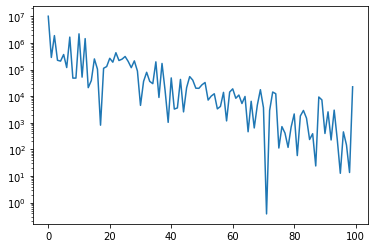

In [33]:
plt.plot(loss)
plt.yscale('log')

In [34]:
model.losses

[<tf.Tensor: shape=(), dtype=float32, numpy=-0.0010097395>]

In [35]:
model.layers[3].trainable_weights

[<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0097394>]

In [36]:
# Final RDF
model.rdf.reset_states()
sample_cgmodel(1e4)
final_rdf = model.rdf.result().numpy()

In [37]:
final_rdf[1,:]

array([0.02500005, 0.07499987, 0.125     , 0.17499965, 0.22499974,
       0.27500048, 0.32500044, 0.375     , 0.42500037, 0.47499907,
       0.525001  , 0.5749989 , 0.625     , 0.6750014 , 0.7249998 ,
       0.7749998 , 0.8249983 , 0.875     , 0.92500174, 0.9750014 ,
       1.0249983 , 1.074998  , 1.125     , 1.1750021 , 1.2250024 ,
       1.2749976 , 1.3249984 , 1.375     , 1.4250005 , 1.4750029 ,
       1.5249969 , 1.5750006 , 1.625     , 1.6749988 , 1.7250034 ,
       1.7749965 , 1.8250022 , 1.875     , 1.9249972 , 1.9750038 ,
       2.0249963 , 2.0750034 , 2.125     , 2.1749961 , 2.225004  ,
       2.2749958 , 2.3250043 , 2.375     , 2.4249954 , 2.4750042 ,
       2.5249958 , 2.5750048 , 2.625     , 2.6749947 , 2.7250023 ,
       2.774998  , 2.8250058 , 2.875     , 2.9249942 , 2.9750001 ,
       3.025     , 3.0750062 , 3.125     , 3.1749935 , 3.224998  ,
       3.2750022 , 3.3250067 , 3.375     , 3.4249933 , 3.4749966 ,
       3.5250037 , 3.575007  , 3.625     , 3.674993  , 3.72499

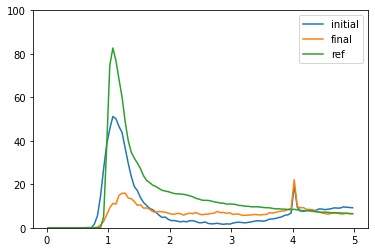

In [41]:
plt.plot(init_rdf[1,:], init_rdf[0,:], label='initial')
plt.plot(final_rdf[1,:], final_rdf[0,:], label='final')
plt.plot(ref_rdf[1,:], ref_rdf[0,:], label='ref')
plt.ylim(0,100)
plt.legend()

In [50]:
r = tf.linspace(0.5, 5, 1000)
output = htf.compute_pairwise(model, r)

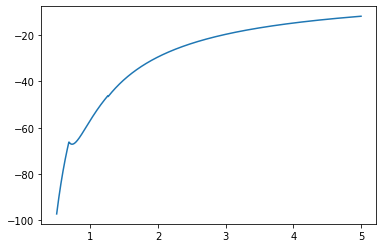

In [55]:
plt.plot(r, output[1])